In [1]:
import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import numpy as np
import pandas as pd
import astropy

In [3]:
print(astropy.__version__)
import lightkurve as lk

import matplotlib.gridspec as gridspec

3.1.2


In [34]:
#------------------------------Finding Downloaded TESS Data Files --------------------------------------
path = '/Users/felizd/Desktop/Felix/TESSdata/' #location of where I put downloaded files
path = '/Users/felizd/Desktop/Felix/TESSdata/' #location of where I put downloaded files

data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

print ("number of files: ",len(data)) #number of files)

# for d in range(len(data)):
#     print ("data set #", d+1 ," : ", data[d]) #I added the d+1 because python does zero-indexing (https://en.wikipedia.org/wiki/Zero-based_numbering)
#     print ("")

number of files:  1961


/Users/felizd/Desktop/Felix/TESSdata/Sector01/curves/clean/140689204_sector01_4_2.lc
criterion:  0.000390015600624025
3*std: 0.0063636230599857105


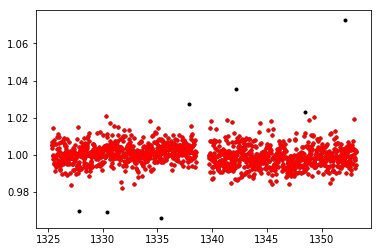

In [30]:
Nsig=3; bin_size=5; window_size=201

def ChauventsCriteron(x, y, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]
    print ("criterion: ", criterion)
    print ("3*std:", std(y))
#     return filter                # Use boolean array outside this function
    return xf,yf


print(data[d])
time     = np.transpose(np.loadtxt(data[d]))[0] #first  (zero indexing in python) column 
mag      = np.transpose(np.loadtxt(data[d]))[1] #second (zero indexing in python) column 
magerror = np.transpose(np.loadtxt(data[d]))[2] #third (zero indexing in python) column 

flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
fluxerror = flux*(10.0**(magerror/2.5)-1.0)

t2,f2 = ChauventsCriteron(time,flux)
# print( len(mask))
plt.plot(time,flux,'k.')
plt.plot(t2,f2,'r.')
plt.show()

In [40]:
def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]
    print ("criterion: ", criterion)
    print ("3*std:", std(y))
#     return filter                # Use boolean array outside this function
    return xf,yf,zf

run BLS
criterion:  0.000390015600624025
3*std: 0.00328762827463706
66
6.830000000000001
1.077176333333023


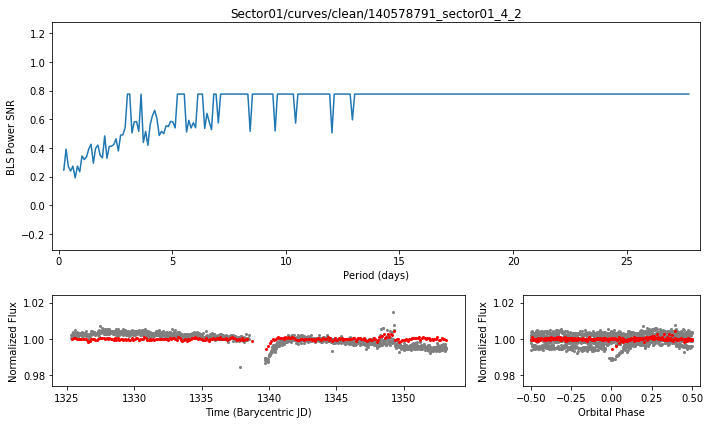

In [ ]:
print ("run BLS")
from astropy.stats import BoxLeastSquares

Nsig=3; bin_size=5; window_size=201; spacing=0.02
# for d in range(len(data)): #creating a for loop to show light curve figures for all files
for d in range(20): #creating a for loop to show light curve figures for all files    
    time     = np.transpose(np.loadtxt(data[d]))[0] #first  (zero indexing in python) column 
    mag      = np.transpose(np.loadtxt(data[d]))[1] #second (zero indexing in python) column 
    magerror = np.transpose(np.loadtxt(data[d]))[2] #third (zero indexing in python) column 
    
    flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
    fluxerror = flux*(10.0**(magerror/2.5)-1.0)
    
    #removing outliers with Chauvenet's criterion
    t2,f2,fe2 = ChauventsCriteron(time,flux,fluxerror)
    lc = lk.LightCurve(t2,f2,fe2)
    detrended_lc = lc.flatten(window_length=window_size).bin(binsize=bin_size)
    
    
    #detrending
#     lc = lk.LightCurve(time,flux,fluxerror)
#     detrended_lc = lc.flatten(window_length=window_size).bin(binsize=bin_size).remove_outliers(sigma=Nsig,iters=None)
    
    #doing BLS search:
    bls = BoxLeastSquares(detrended_lc.time, detrended_lc.flux, detrended_lc.flux_err)
    periods = np.arange(0.23, (max(detrended_lc.time)-min(detrended_lc.time)), 0.1)
    durations = np.arange((1.0/24.0), (5.0/24.0), 0.1) #1 hr to 5 hrs
    periodogram = bls.power(periods, durations,objective='snr')
    
    #phase folding with best BLS model
    index = np.argmax(periodogram.power); print(index)
    best_period = periodogram.period[index]; print(best_period)
    best_t0 = periodogram.transit_time[index]; print(best_t0)
    detrendedphasefoldedlc = [detrended_lc.fold(period=best_period,t0=best_t0).phase,detrended_lc.fold(period=best_period,t0=best_t0).flux, detrended_lc.fold(period=best_period,t0=best_t0).flux_err]
    phasefoldedlc = [lc.fold(period=best_period,t0=best_t0).phase,lc.fold(period=best_period,t0=best_t0).flux, lc.fold(period=best_period,t0=best_t0).flux_err]

    
    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


    f = plt.figure(figsize=(10,6))
    ax1 = f.add_subplot(gs1[:-1, :])
    ax2 = f.add_subplot(gs1[-1, :-1])
    ax3 = f.add_subplot(gs1[-1, -1])

    
    
    
    
    ax1.plot(periodogram.period, periodogram.power, rasterized=True) 
    plt.xticks(np.arange(0.0, 31.0, 1.0))
    ax1.set_title(str(data[d][37:-3]))
    ax1.set_xlabel("Period (days)")
    ax1.set_xlim(np.min(periodogram.period)-0.5, np.max(periodogram.period)+0.5)
    ax1.set_ylabel("BLS Power SNR")
    ax1.set_ylim(np.min(periodogram.power)-0.5, np.max(periodogram.power)+0.5)

    
    ax2.plot(detrended_lc.time,detrended_lc.flux,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size)+", binsize: "+str(bin_size)+", Nsig: "+str(Nsig))
    ax2.plot(time,flux,c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
#     ax2.legend(loc='upper right')
#     ax2.set_ylim(0.985,1.015)
    ax2.set_ylim(np.min(detrended_lc.flux)-spacing, np.max(detrended_lc.flux)+spacing)
    ax2.set_xlabel("Time (Barycentric JD)")
    ax2.set_ylabel("Normalized Flux") 

    ax3.plot(detrendedphasefoldedlc[0],detrendedphasefoldedlc[1],c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size)+", binsize: "+str(bin_size)+", Nsig: "+str(Nsig))
    ax3.plot(phasefoldedlc[0],phasefoldedlc[1],c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
#     ax3.legend(loc='upper right')
    ax3.set_xlabel("Orbital Phase")
    ax3.set_ylabel("Normalized Flux") 
#     ax3.set_ylim(0.985,1.015)
    ax3.set_ylim(np.min(detrended_lc.flux)-spacing, np.max(detrended_lc.flux)+spacing)
    ax3.set_xticks(np.arange(np.min(phasefoldedlc[0]),np.max(phasefoldedlc[0])+0.25,0.25))
    gs1.tight_layout(f)

    plt.savefig("plots/"+str(data[d][59:-3])+".png", dpi=400, rasterized=True,bbox_inches='tight')        
    plt.show()    
    print( "") #adds space between figures